# ANN to Predict Subject
Using modal representation, can we tell which subject it came from with DMD modes? Trying a [second data set](https://www.physionet.org/content/eegmmidb/1.0.0/) 

- w/ 60 modes
- split each trial into eight smaller trials
- 32 channels


Setup: Javascript and ipynb stuff

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import glob

In [11]:
path=pathlib.Path('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/DMD_eegmmi')
path

PosixPath('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/DMD_eegmmi')

## Set filenames and labels

In [25]:
filenames = glob.glob('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/DMD_eegmmi/robots/*')

In [26]:
names = [os.path.splitext(os.path.basename(x))[0] for x in glob.glob('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/DMD_eegmmi/robots/*')]

In [27]:
subject=[]
for i in range(0,len(names)):
    if names[i][2]=='T':
        subject.append(names[i][1])
    elif names[i][3]=='T':
        subject.append(names[i][1:3])
    elif names[i][4]=='T':
        subject.append(names[i][1:4])

In [28]:
df1=DataFrame(names,columns=['filename'])
df2=DataFrame(subject,columns=['subject'])
frames=[df1,df2]
df=pd.concat(frames, axis=1)
df.tail()

,filename,subject
6426,S69T15,69
6427,S32T60,32
6428,S16T56,16
6429,S73T39,73
6430,S72T22,72


In [30]:
path=pathlib.Path('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/DMD_eegmmi')
path

PosixPath('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/DMD_eegmmi')

In [31]:
df.to_csv(path/'labels_proc.csv', index=False)

## Data loader

In [32]:
df = pd.read_csv(path/'labels_proc.csv') #load labels
df.tail()

,filename,subject
6426,S69T15,69
6427,S32T60,32
6428,S16T56,16
6429,S73T39,73
6430,S72T22,72


## Data loader

In [33]:
src = (ImageList.from_csv(path, 'labels_proc.csv', folder='robots', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['subject'],label_cls=CategoryList))

In [34]:
tfms=get_transforms()
tf_final=[[tfms[0][0],tfms[0][4],tfms[0][5],tfms[0][6]],None]

In [35]:
data = (src.transform(tf_final, size=200)
        .databunch(bs=4).normalize())

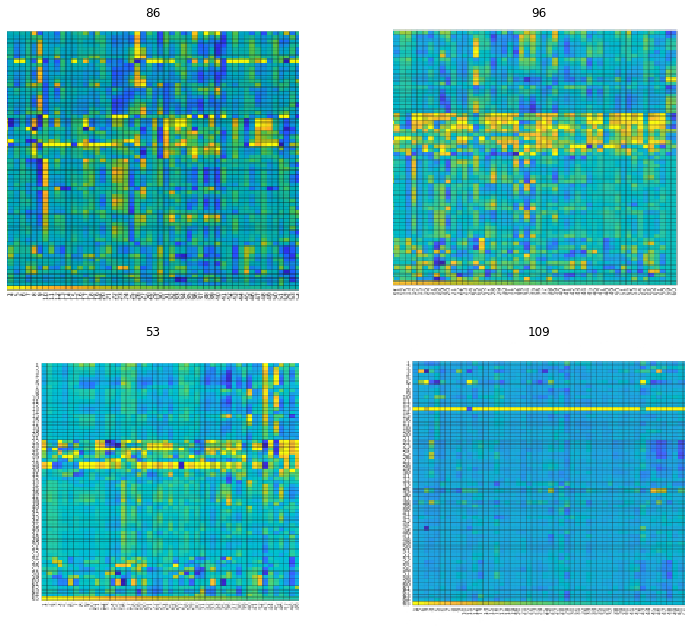

In [36]:
data.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [37]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [38]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 100, 100]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 100, 100]       128        True      
______________________________________________________________________
ReLU                 [64, 100, 100]       0          False     
______________________________________________________________________
MaxPool2d            [64, 50, 50]         0          False     
______________________________________________________________________
Conv2d               [64, 50, 50]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 50, 50]         128        True      
______________________________________________________________________
ReLU                 [64, 50, 50]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


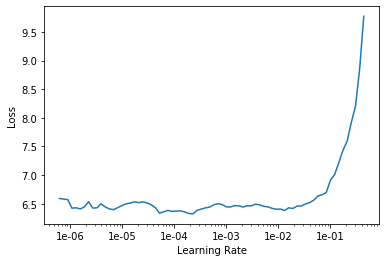

In [39]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [40]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.show_results()

## Train the whole network

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr))

In [28]:
data = (src.transform(tf_final, size=512)
        .databunch(bs=4).normalize())

In [29]:
learn.data=data

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


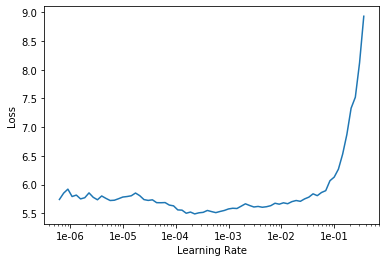

In [30]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,5.377484,4.548396,0.048989,02:03
1,4.675765,4.134668,0.067652,02:03
2,4.322861,3.576028,0.146190,02:18
3,3.823285,3.622764,0.279938,02:17
4,3.564419,4.216961,0.355365,02:20


In [32]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,3.867013,7.679685,0.267496,02:20
1,3.862395,5.273993,0.260498,02:07
2,3.430906,24.969770,0.422240,02:04
3,2.987125,5.326338,0.646967,02:05
4,2.614045,2.144356,0.713064,02:06


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


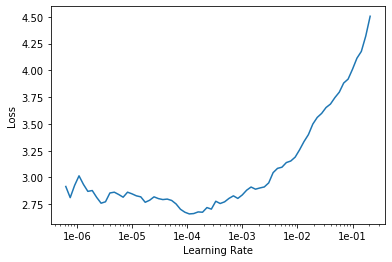

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.633837,5.674519,0.707621,02:44
1,2.392033,4.999889,0.748834,02:44
2,2.121501,3.488216,0.793935,02:44
3,1.987886,9.076536,0.751944,02:46
4,2.042341,5.249332,0.770607,02:45


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


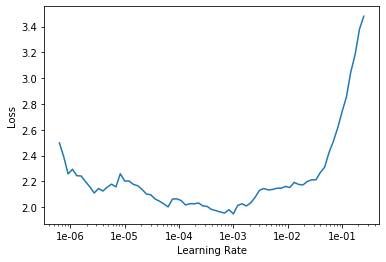

In [35]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [36]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.939352,9.979654,0.772162,02:03
1,1.816660,2.609112,0.821151,02:03
2,1.684891,3.609136,0.869362,02:04
3,1.586755,1.727061,0.877138,02:04
4,1.599432,2.960079,0.871695,02:05


In [39]:
learn.fit_one_cycle(10, slice(lr), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.980655,0.458412,0.937014,02:04
1,1.048729,0.407007,0.929238,02:07
2,0.938268,0.293172,0.950233,02:10
3,0.966782,0.256165,0.958009,02:08
4,0.993877,0.305638,0.944790,02:06
5,0.941165,0.227924,0.953344,02:04
6,0.727007,0.210823,0.963453,02:06
7,0.773873,0.245621,0.954121,02:13
8,0.644183,0.210586,0.962675,02:07
9,0.586200,0.205500,0.962675,02:07


In [43]:
learn.fit_one_cycle(5, slice(lr), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.670881,0.190921,0.967341,02:05
1,0.933366,0.250692,0.957232,02:06
2,0.688395,0.261217,0.960342,02:09
3,0.687719,0.182395,0.972006,02:06
4,0.608552,0.186958,0.966563,02:06


## Interpret and Results

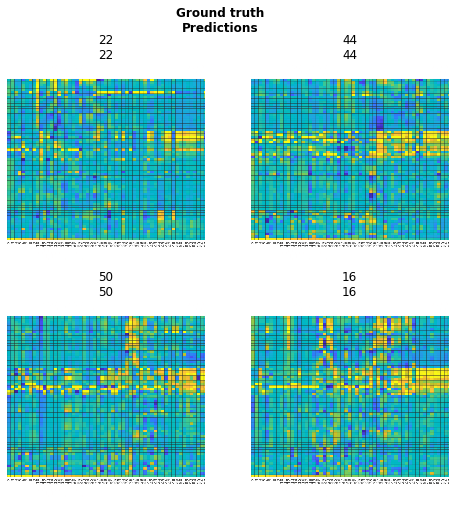

In [44]:
learn.show_results()

In [45]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

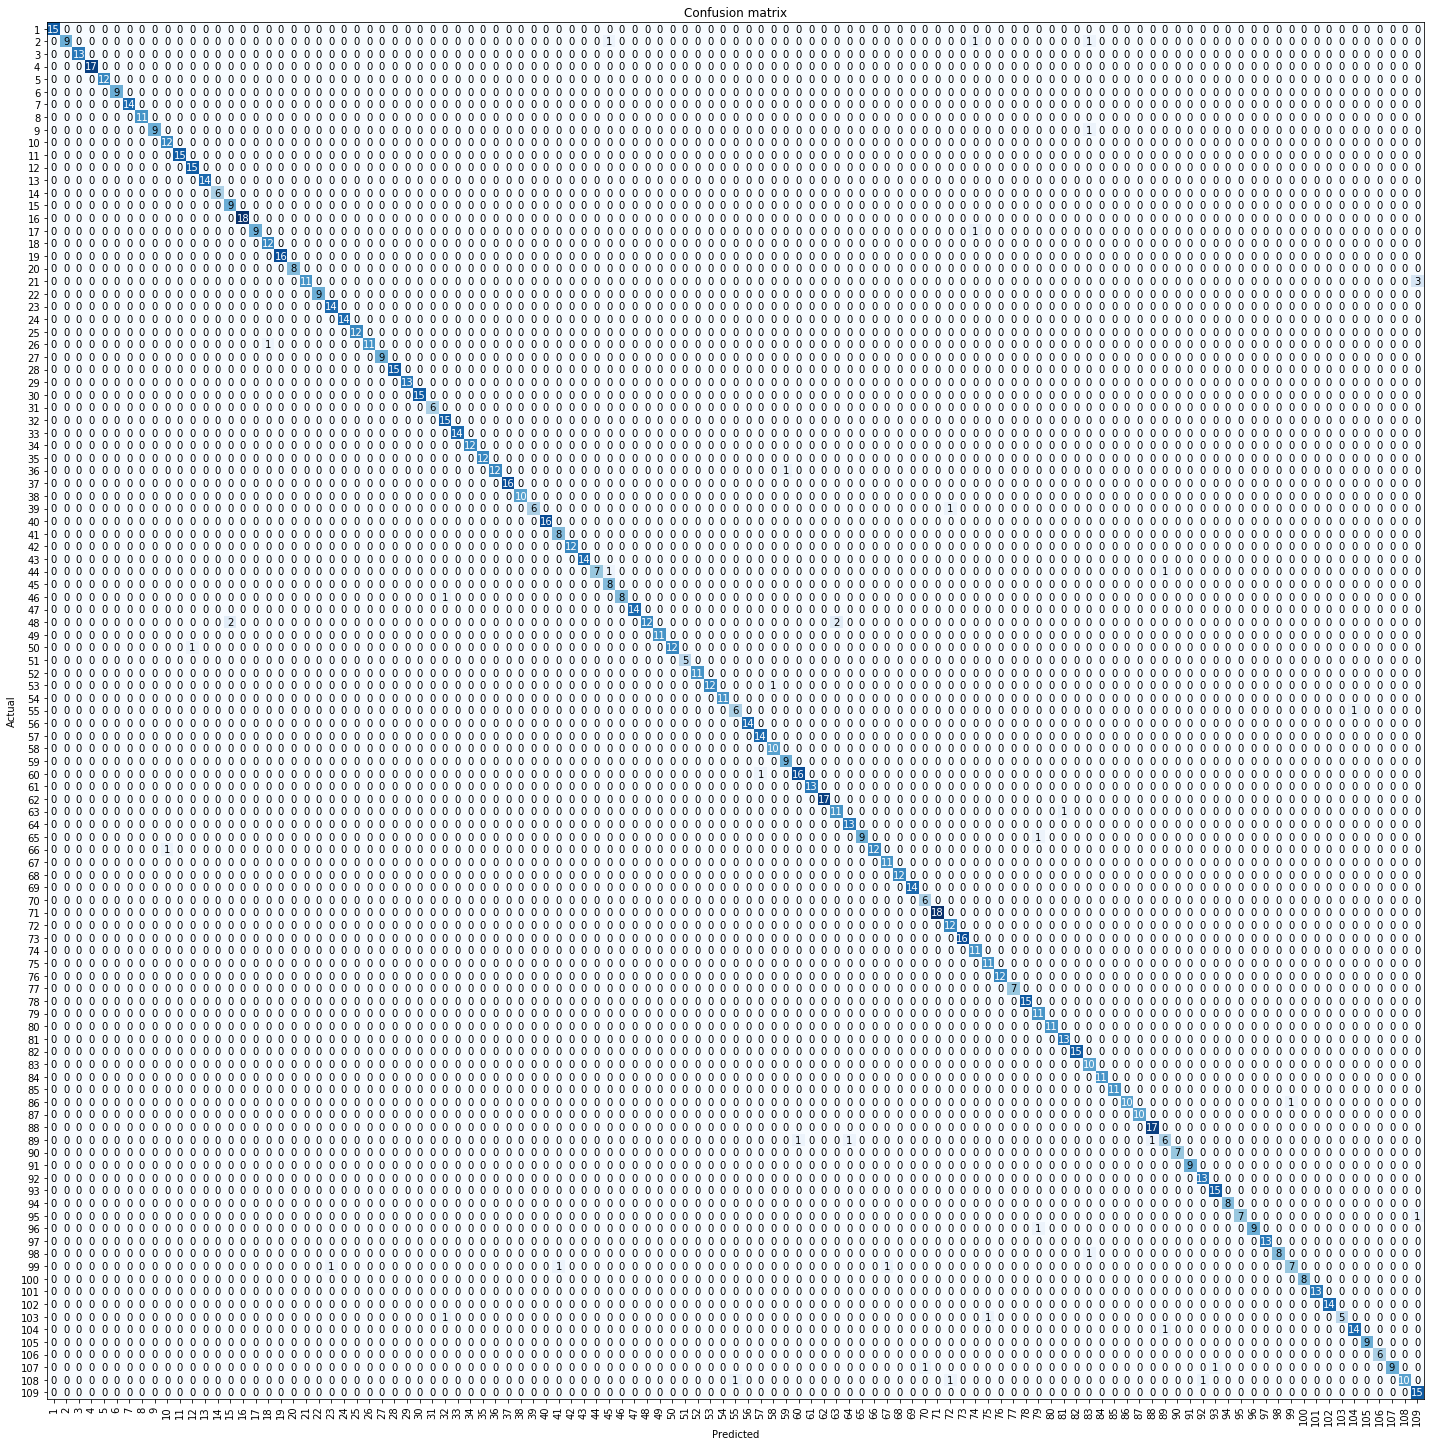

In [46]:
interp.plot_confusion_matrix(figsize=(20,20))

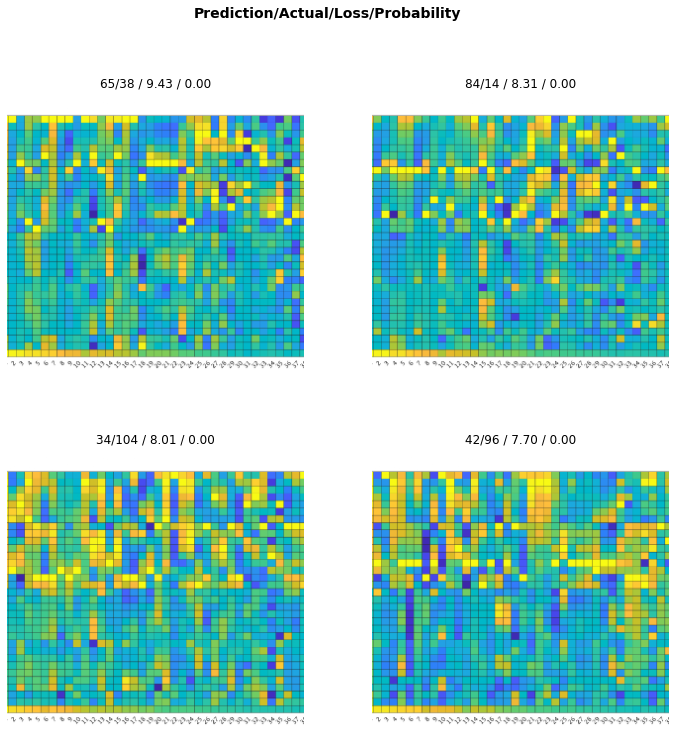

In [22]:
interp.plot_top_losses(4)